In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from scipy.ndimage import gaussian_filter1d



## Latent PKPD Model

In [5]:
def latent_variable(t, phi):
    """ Compute the polynomial latent variable Q(t) based on the given parameters. """
    return sum(phi[i] * (t ** i) for i in range(len(phi)))

def pkpd_model(t, y, params, phi):
    C, x = y  # Drug concentration and cancer volume
    k_elim, k_growth, k_drug_effect = params

    # Compute the latent variable Q(t)
    Q = latent_variable(t, phi)

    # Drug administration modeled as Bernoulli process (0 or 1)
    a_t = np.random.binomial(1, 0.5)  # Probability of administering drug at time t

    # Define the rate equations
    dCdt = -k_elim * C + (a_t * 5)  # Drug concentration change
    dXdt = k_growth * x * (1 - (x / 100)) + Q - k_drug_effect * a_t * C  # Cancer volume change influenced by Q

    return [dCdt, dXdt] 

In [6]:
def generate_pkpd_data(num_individuals, population_params, phi, t):
    results_concentration = []
    results_volume = []

    for _ in range(num_individuals):
        y0 = [10, 1]  # Initial drug concentration and cancer volume
        # Solve ODE using solve_ivp
        res = solve_ivp(pkpd_model, [t[0], t[-1]], y0, args=(population_params, phi), t_eval=t)
        results_concentration.append(res.y[0])
        results_volume.append(res.y[1])

    results_concentration = np.array(results_concentration)
    results_volume = np.array(results_volume)

    mean_concentration = np.mean(results_concentration, axis=0)
    mean_volume = gaussian_filter1d(np.mean(results_volume, axis=0), sigma=2)

    # Calculate latent variables for visualization
    latent_values = latent_variable(t, phi)

    return results_concentration, results_volume, mean_concentration, mean_volume, latent_values

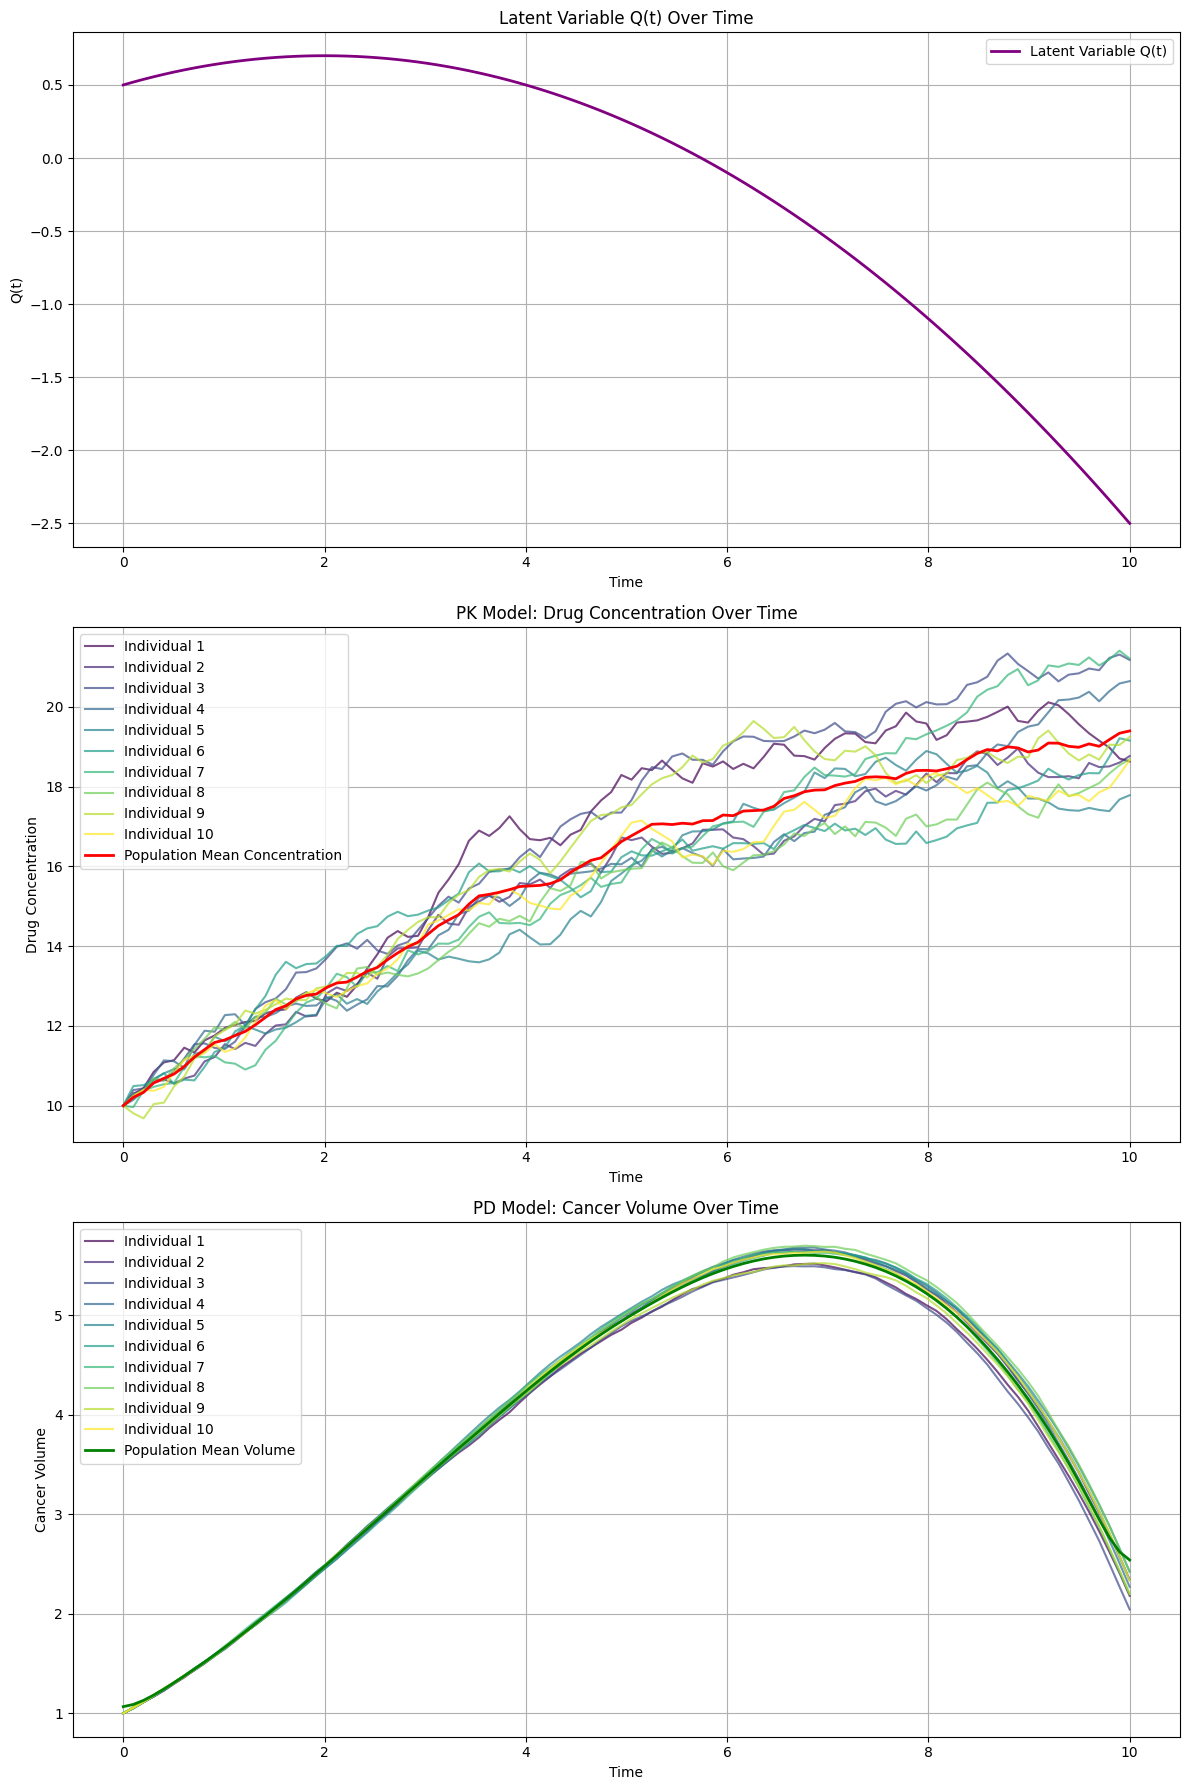

In [7]:
# Example Parameters
population_parameters = (0.1, 0.1, 0.01)  # k_elim, k_growth, k_drug_effect
time_points = np.linspace(0, 10, 100)  # Time points for the simulation

# Latent variable polynomial coefficients (change degree as needed)
phi = [0.5, 0.2, -0.05]  # Example coefficients for Q(t) = 0.5 + 0.2*t - 0.05*t^2 (quadratic)

# Generate Data
num_individuals = 10
data = generate_pkpd_data(num_individuals, population_parameters, phi, time_points)
results_concentration, results_volume, mean_concentration, mean_volume, latent_values = data

# Color map for individual plots
colors = plt.cm.viridis(np.linspace(0, 1, num_individuals))

# Plotting the results
plt.figure(figsize=(12, 18))

# Plot Latent Variable Q(t)
plt.subplot(3, 1, 1)
plt.plot(time_points, latent_values, color='purple', linewidth=2, label='Latent Variable Q(t)')
plt.title('Latent Variable Q(t) Over Time')
plt.xlabel('Time')
plt.ylabel('Q(t)')
plt.legend()
plt.grid()

# Plot Drug Concentration
plt.subplot(3, 1, 2)
for i, concentration in enumerate(results_concentration):
    plt.plot(time_points, concentration, color=colors[i], alpha=0.7, label=f'Individual {i+1}')

plt.plot(time_points, mean_concentration, color='red', linewidth=2, label='Population Mean Concentration')
plt.title('PK Model: Drug Concentration Over Time')
plt.xlabel('Time')
plt.ylabel('Drug Concentration')
plt.legend()
plt.grid()

# Plot Cancer Volume
plt.subplot(3, 1, 3)
for i, volume in enumerate(results_volume):
    plt.plot(time_points, volume, color=colors[i], alpha=0.7, label=f'Individual {i+1}')

plt.plot(time_points, mean_volume, color='green', linewidth=2, label='Population Mean Volume')
plt.title('PD Model: Cancer Volume Over Time')
plt.xlabel('Time')
plt.ylabel('Cancer Volume')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Fit VL-INSITE model

In [8]:
n_individuals = 10

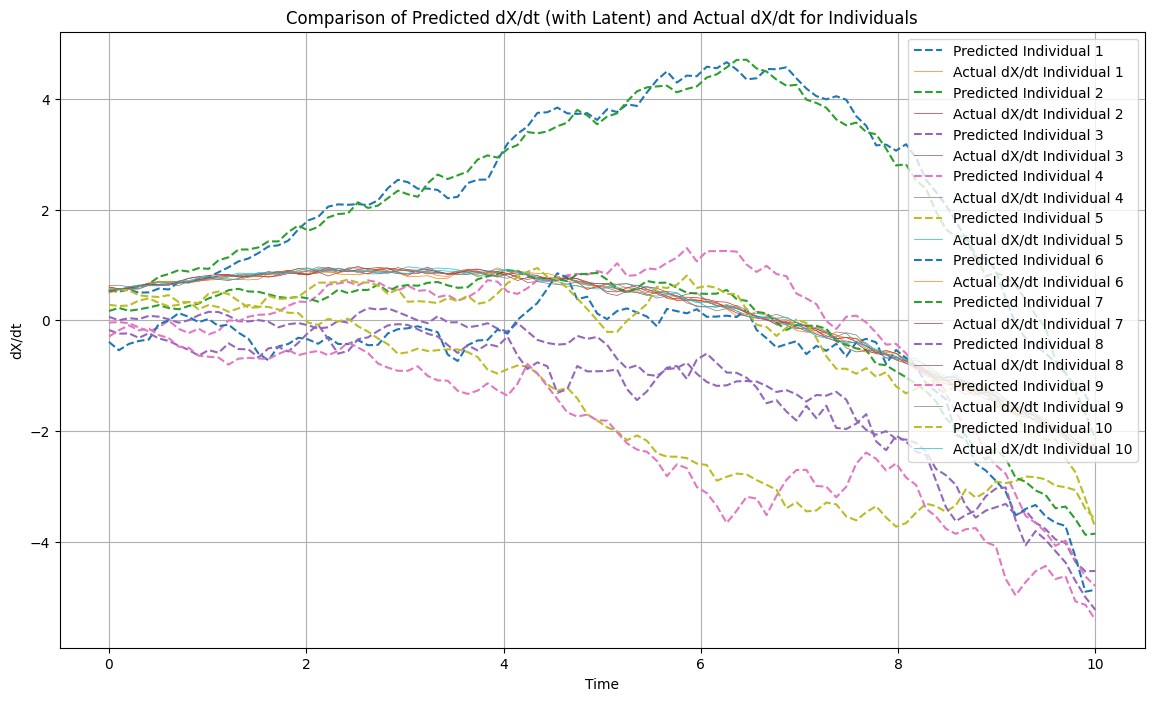

In [17]:
# Fit polynomial latent dynamics for each individual's concentration
def fit_latent_dynamics(t, Z, degree):
    """Fit polynomial coefficients for latent dynamics."""
    T = np.vstack([t**k for k in range(degree + 1)]).T
    coeffs = np.linalg.lstsq(T, Z, rcond=None)[0]
    return coeffs


def latent_variable(t, phi):
    """Compute the polynomial latent variable Q(t) based on the given parameters."""
    return sum(phi[i] * (t ** i) for i in range(len(phi)))

# Function to build feature library for SINDy including latent variable impact
def build_feature_library_latent(X, Z, Q_t):
    A = np.column_stack([X, Z, Q_t, X * Z, X * Q_t, Z * Q_t, X**2, Z**2])
    return A

# Fine-tune for individual-specific dynamics using their fitted latent coefficients
def fine_tune_individual_dynamics(X_i, dX_dt_i, feature_library, beta_est, lambda_reg=0.1):
    def loss_function(beta_i):
        mse_loss = np.mean((dX_dt_i - feature_library @ beta_i) ** 2)
        reg_loss = lambda_reg * np.sum((beta_est - beta_i) ** 2)
        return mse_loss + reg_loss

    res = minimize(loss_function, beta_est, method="L-BFGS-B")
    return res.x

# Fit latent dynamics for the concentration of each individual
latent_coeffs_list = []
for i in range(n_individuals):
    latent_coeffs = fit_latent_dynamics(time_points, results_volume[i], degree=2)
    latent_coeffs_list.append(latent_coeffs)
    
# Calculate dX/dt using finite differences for the combined dataset
dX_dt = np.array([np.gradient(results_volume[i], time_points) for i in range(n_individuals)])

# Build the feature library using the combined dataset, now including latent effects
feature_libraries = [build_feature_library_latent(results_concentration[i], results_volume[i], latent_variable(time_points, latent_coeffs_list[i])) for i in range(n_individuals)]

# Initialize beta estimates, which should have the same size as the features used
individual_betas = []
for i in range(n_individuals):
    X_i = results_concentration[i]  # Individual drug concentration
    Z_i = results_volume[i]  # Individual cancer volume
    dX_dt_i = np.gradient(Z_i, time_points)  # Calculate individual dX/dt

    # Build feature library for the individual
    feature_library_i = build_feature_library_latent(X_i, Z_i, latent_variable(time_points, latent_coeffs_list[i]))

    # Start with zero estimates for beta
    beta_est = np.zeros(feature_library_i.shape[1])
    beta_individual = fine_tune_individual_dynamics(X_i, dX_dt_i, feature_library_i, beta_est)
    individual_betas.append(beta_individual)

# Now you can proceed with predicting dX/dt incorporating the fitted coefficients
# Update the predict function to include latent influences
def predict_dX_dt(X, V, individual_betas):
    """Predict dX/dt for all individuals considering dynamically computed latent variable Q."""
    dX_dt_predictions = []

    for i, beta_individual in enumerate(individual_betas):
        Q_t = latent_variable(time_points, latent_coeffs_list[i])  # Use the individual's latent coeffs

        dX_dt_i = (beta_individual[0] * X[i] * (1 - X[i] / 10) +
                   beta_individual[1] * V +
                   beta_individual[2] * Q_t +
                   beta_individual[3] * X[i] * V +
                   beta_individual[4] * X[i] * Q_t +
                   beta_individual[5] * V * Q_t)
        
        dX_dt_predictions.append(dX_dt_i)
    
    return np.array(dX_dt_predictions)


# Predict dX/dt for all individuals including latent influence in prediction
V = np.mean(results_volume, axis=0)  # Average cancer volume across individuals

# Compute predicted dX/dt using the function that incorporates latent effects
dX_dt_predicted = predict_dX_dt(results_concentration, V, individual_betas)

# Function to predict cancer volume from predicted dX/dt with latent influences
def predict_cancer_volume(dX_dt, initial_volume, time_points):
    predicted_volumes = []
    
    for dX in dX_dt:
        def dXdt(t, x):
            return dX[int(np.clip(t, 0, len(dX) - 1))]  # Ensure appropriate indexing

        # Integrate to obtain the cancer volume over time
        sol = solve_ivp(dXdt, [time_points[0], time_points[-1]], [initial_volume], t_eval=time_points)
        predicted_volume = sol.y[0]  # Extracting the predicted cancer volume
        predicted_volumes.append(predicted_volume)

    return np.array(predicted_volumes)

# Predict cancer volumes for all individuals based on the predicted dX/dt including latent influences
predicted_cancer_volumes_latent = predict_cancer_volume(dX_dt_predicted, initial_volume=1, time_points=time_points)

# Visualize predicted vs actual dX/d    t
plt.figure(figsize=(14, 8))

for i in range(n_individuals):
    plt.plot(time_points, dX_dt_predicted[i], label=f"Predicted Individual {i + 1}", linestyle='--')
    plt.plot(time_points, np.gradient(results_volume[i], time_points), label=f"Actual dX/dt Individual {i + 1}", linewidth=0.5)

plt.xlabel("Time")
plt.ylabel("dX/dt")
plt.title("Comparison of Predicted dX/dt (with Latent) and Actual dX/dt for Individuals")
plt.legend()
plt.grid()
plt.show()


In [13]:
# Function to calculate Mean Squared Error
def calculate_mse(true_values, predicted_values):
    return np.mean((true_values - predicted_values) ** 2)

# Function to calculate R² (Goodness-of-Fit)
def calculate_r_squared(true_values, predicted_values):
    ss_res = np.sum((true_values - predicted_values) ** 2)  # Residual sum of squares
    ss_tot = np.sum((true_values - np.mean(true_values)) ** 2)  # Total sum of squares
    return 1 - (ss_res / ss_tot)  # R² value

# After predicting dX/dt for all individuals, compute metrics
mse_values = []
r_squared_values = []
individual_dX_dt = [np.gradient(results_volume[i], time_points) for i in range(n_individuals)]


for i in range(n_individuals):
    mse = calculate_mse(individual_dX_dt[i], dX_dt_predicted[i])
    r_squared = calculate_r_squared(individual_dX_dt[i], dX_dt_predicted[i])
    mse_values.append(mse)
    r_squared_values.append(r_squared)

# Print the MSE and R² for each individual
for i in range(n_individuals):
    print(f"Individual {i + 1} - MSE: {mse_values[i]:.4f}, R²: {r_squared_values[i]:.4f}")

# Calculate population-level metrics
population_mse = calculate_mse(np.mean(individual_dX_dt, axis=0), np.mean(dX_dt_predicted, axis=0))
population_r_squared = calculate_r_squared(np.mean(individual_dX_dt, axis=0), np.mean(dX_dt_predicted, axis=0))

# Print population metrics
print(f"Population - MSE: {population_mse:.4f}, R²: {population_r_squared:.4f}")

Individual 1 - MSE: 7.4065, R²: -7.9547
Individual 2 - MSE: 6.9725, R²: -7.2220
Individual 3 - MSE: 1.5639, R²: -0.8024
Individual 4 - MSE: 0.6813, R²: 0.2295
Individual 5 - MSE: 4.1207, R²: -3.9344
Individual 6 - MSE: 1.0253, R²: -0.1941
Individual 7 - MSE: 0.2901, R²: 0.6717
Individual 8 - MSE: 2.4457, R²: -1.8602
Individual 9 - MSE: 5.4389, R²: -5.4092
Individual 10 - MSE: 0.1607, R²: 0.8116
Population - MSE: 0.2717, R²: 0.6819


### Average MSE : 10 run

In [33]:
# Settings for the experiment
num_individuals = 10
num_runs = 50  # Number of simulations
mse_values = []

for run in range(num_runs):
    # Generate Data
    results_concentration, results_volume, _, _, _ = generate_pkpd_data(num_individuals, population_parameters, phi, time_points)

    # Calculate dX/dt for each individual
    individual_dX_dt = [np.gradient(results_volume[i], time_points) for i in range(num_individuals)]

    # Fit polynomial latent dynamics for each individual's concentration
    latent_coeffs_list = []
    for i in range(num_individuals):
        latent_coeffs = fit_latent_dynamics(time_points, results_volume[i], degree=2)
        latent_coeffs_list.append(latent_coeffs)

    # Build the feature library without latent variables
    feature_libraries_latent = [build_feature_library_latent(results_concentration[i], results_volume[i], latent_variable(time_points, latent_coeffs_list[i])) for i in range(num_individuals)]

    # Initialize beta estimates
    individual_betas_latent = []

    for i in range(num_individuals):
        X_i = results_concentration[i]  # Individual drug concentration
        Z_i = results_volume[i]  # Individual cancer volume
        dX_dt_i = np.gradient(Z_i, time_points)  # Calculate individual dX/dt

        # Build feature library for the individual
        feature_library_i = build_feature_library_latent(X_i, Z_i, latent_variable(time_points, latent_coeffs_list[i]))

        # Start with zero estimates for beta
        beta_est = np.zeros(feature_library_i.shape[1])
        beta_individual = fine_tune_individual_dynamics(X_i, dX_dt_i, feature_library_i, beta_est)
        individual_betas_latent.append(beta_individual)

    # Predict dX/dt using inferred coefficients for each individual without latent influence
    V = np.mean(results_volume, axis=0)  # Average cancer volume across individuals
    dX_dt_predicted_latent = predict_dX_dt(results_concentration, V, individual_betas_latent)

    # Calculate MSE for this run
    mse_run = []
    for i in range(num_individuals):
        mse = calculate_mse(individual_dX_dt[i], dX_dt_predicted_latent[i])
        mse_run.append(mse)

    # Append the run's MSE values to the overall list
    mse_values.append(mse_run)

# Convert to array for further analysis
mse_values = np.array(mse_values)

# Calculate average MSE and standard deviation across runs for each individual
average_mse = np.mean(mse_values, axis=0)
std_deviation_mse = np.std(mse_values, axis=0)

# Print the results
for i in range(num_individuals):
    print(f"Individual {i + 1} - Average MSE: {average_mse[i]:.4f}, Standard Deviation: {std_deviation_mse[i]:.4f}")

# Calculate and print overall averages for the population
overall_average_mse = np.mean(average_mse)
overall_std_deviation_mse = np.mean(std_deviation_mse)

print(f"Overall Average MSE across all individuals: {overall_average_mse:.4f}, Overall Standard Deviation: {overall_std_deviation_mse:.4f}")

Individual 1 - Average MSE: 6.2388, Standard Deviation: 10.6387
Individual 2 - Average MSE: 7.0373, Standard Deviation: 8.9482
Individual 3 - Average MSE: 5.7766, Standard Deviation: 13.0347
Individual 4 - Average MSE: 6.7935, Standard Deviation: 9.9148
Individual 5 - Average MSE: 7.4361, Standard Deviation: 11.5595
Individual 6 - Average MSE: 6.3854, Standard Deviation: 8.3746
Individual 7 - Average MSE: 9.2472, Standard Deviation: 19.2419
Individual 8 - Average MSE: 6.7564, Standard Deviation: 11.2346
Individual 9 - Average MSE: 4.3454, Standard Deviation: 7.1356
Individual 10 - Average MSE: 5.5060, Standard Deviation: 9.0376
Overall Average MSE across all individuals: 6.5523, Overall Standard Deviation: 10.9120


## Predict Cancer Volume

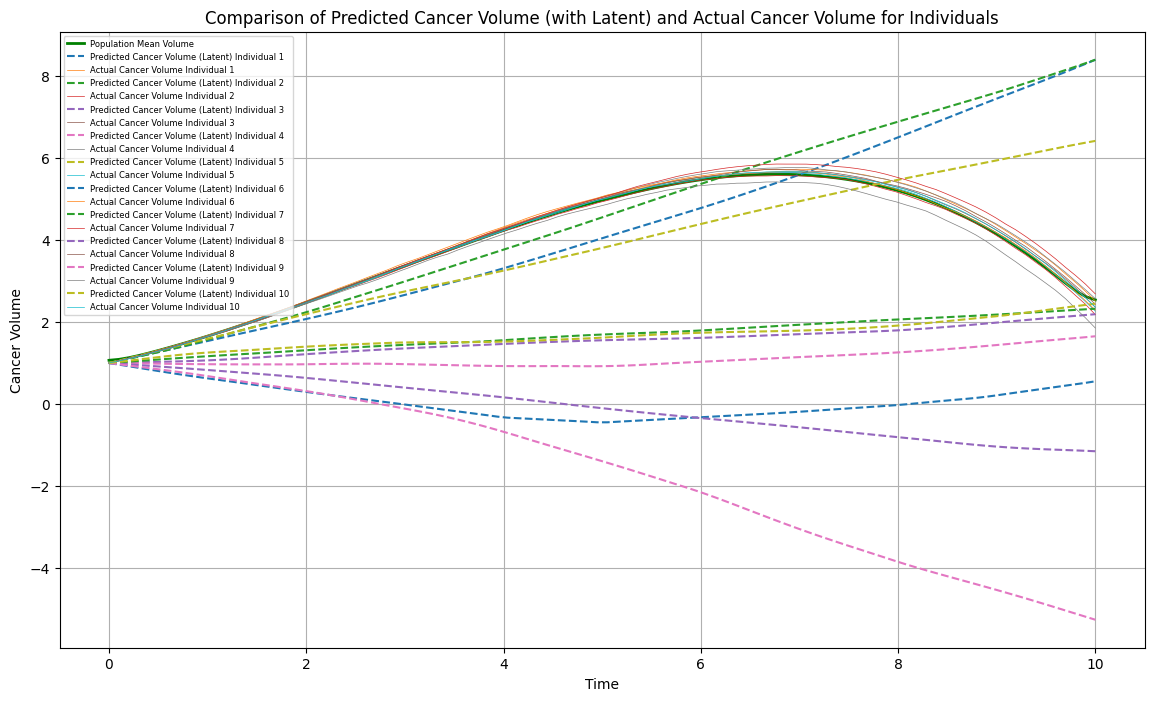

In [23]:
# Function to predict cancer volume from predicted dX/dt values
def predict_cancer_volume_from_dxdt(dX_dt, initial_volume, time_points):
    predicted_volumes = []
    
    for dX in dX_dt:
        def dXdt(t, x):
            return dX[int(np.clip(t, 0, len(dX) - 1))]  # Ensure appropriate indexing

        # Solve the ODE to obtain cancer volume over time
        sol = solve_ivp(dXdt, [time_points[0], time_points[-1]], [initial_volume], t_eval=time_points)
        predicted_volume = sol.y[0]  # Extract the predicted cancer volume
        predicted_volumes.append(predicted_volume)

    return np.array(predicted_volumes)

# Predict dX/dt for all individuals using their inferred betas and ground truth latent values
dX_dt_predicted_latent = predict_dX_dt(results_concentration, np.mean(results_volume, axis=0), individual_betas)

# Now, predict cancer volumes for all individuals
predicted_cancer_volumes_latent = predict_cancer_volume_from_dxdt(dX_dt_predicted_latent, initial_volume=1, time_points=time_points)

# Plotting results for individuals and comparisons between predicted and actual cancer volumes
plt.figure(figsize=(14, 8))

# Plot the mean actual volume
plt.plot(time_points, mean_volume, color='green', linewidth=2, label='Population Mean Volume')

# Plot predictions for all individuals
for i in range(n_individuals):
    plt.plot(time_points, predicted_cancer_volumes_latent[i],
             label=f"Predicted Cancer Volume (Latent) Individual {i + 1}", linestyle='--')
    plt.plot(time_points, results_volume[i],
             label=f"Actual Cancer Volume Individual {i + 1}", linewidth=0.5)  # Plot the actual volume

plt.xlabel("Time")
plt.ylabel("Cancer Volume")
plt.title("Comparison of Predicted Cancer Volume (with Latent) and Actual Cancer Volume for Individuals")
plt.legend(fontsize=6)  # You can specify an exact size
plt.grid()
plt.show()

# ###############Treatment Variable Controlled####################

In [123]:
num_individuals = 5

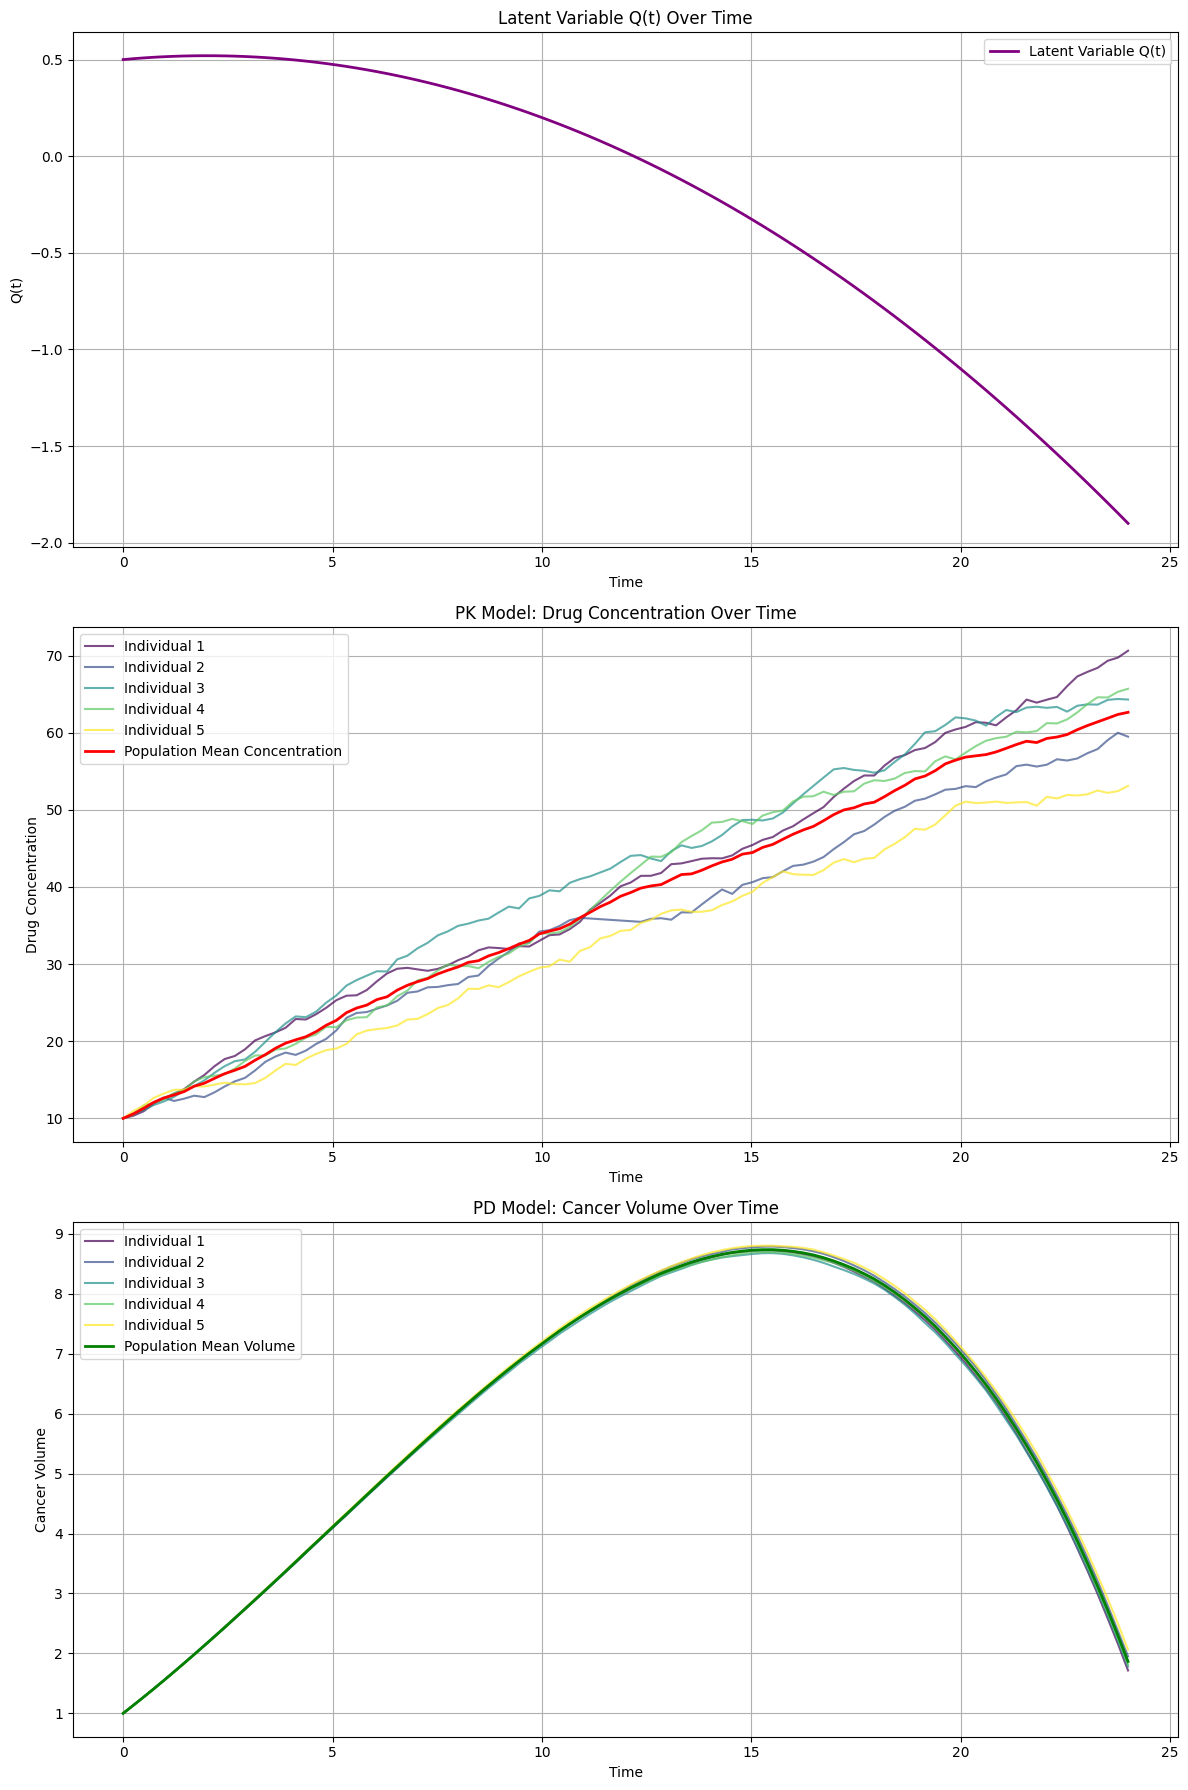

In [124]:
def pkpd_model(t, y, params, phi, treatment_params):
    C, x = y
    k_elim, k_growth, k_drug_effect = params

    Q = latent_variable(t, phi)  # Compute latent variable

    # Use treatment_params to decide on drug administration
    a_t = np.random.binomial(1, treatment_params['probability'])  # Drug given based on probability
    dCdt = -k_elim * C + (a_t * treatment_params['dose'])  # Incorporate dose from treatment
    dXdt = k_growth * x * (1 - (x / 100)) + Q - k_drug_effect * a_t * C

    return [dCdt, dXdt]

def latent_variable(t, phi):
    """ Compute the polynomial latent variable Q(t) based on the given parameters. """
    return sum(phi[i] * (t ** i) for i in range(len(phi)))


# Define population parameters (example values; adjust as suited for your model)
k_elim = 0.01  # Elimination rate constant
k_growth = 0.05  # Growth rate constant
k_drug_effect = 0.001  # Drug effect constant
population_params = [k_elim, k_growth, k_drug_effect]

# Define latent variable coefficients
phi = [0.5, 0.02, -0.005] # Example: Coefficients for latent variables,

# Define time points for simulation
time_points = np.linspace(0, 24, num=100)  # From 0 to 24 hours with 100 points

# Define treatment parameters (example)
treatments = {
    'treatment_a': {'dose': 5, 'probability': 0.5}}

# Now define the generate_pkpd_data function
def generate_pkpd_data(num_individuals, population_params, phi, t):
    results_concentration = []
    results_volume = []

    for _ in range(num_individuals):
        y0 = [10, 1]  # Initial drug concentration and cancer volume
        treatment_params = treatments['treatment_a']  # Choose a treatment for this individual
        res = solve_ivp(pkpd_model, [t[0], t[-1]], y0, args=(population_params, phi, treatment_params), t_eval=t)
        results_concentration.append(res.y[0])
        results_volume.append(res.y[1])

    results_concentration = np.array(results_concentration)
    results_volume = np.array(results_volume)

    mean_concentration = np.mean(results_concentration, axis=0)
    mean_volume = np.mean(results_volume, axis=0)

    # Calculate latent variables for visualization
    latent_values = latent_variable(t, phi)

    return results_concentration, results_volume, mean_concentration, mean_volume, latent_values

# Define the pkpd_model and latent_variable functions here...

# Call the generate_pkpd_data function to run the simulation
results_concentration, results_volume, mean_concentration, mean_volume, latent_values = generate_pkpd_data(num_individuals, population_params, phi, time_points)


# Color map for individual plots
colors = plt.cm.viridis(np.linspace(0, 1, num_individuals))

# Plotting the results
plt.figure(figsize=(12, 18))

# Plot Latent Variable Q(t)
plt.subplot(3, 1, 1)
plt.plot(time_points, latent_values, color='purple', linewidth=2, label='Latent Variable Q(t)')
plt.title('Latent Variable Q(t) Over Time')
plt.xlabel('Time')
plt.ylabel('Q(t)')
plt.legend()
plt.grid()

# Plot Drug Concentration
plt.subplot(3, 1, 2)
for i, concentration in enumerate(results_concentration):
    plt.plot(time_points, concentration, color=colors[i], alpha=0.7, label=f'Individual {i+1}')

plt.plot(time_points, mean_concentration, color='red', linewidth=2, label='Population Mean Concentration')
plt.title('PK Model: Drug Concentration Over Time')
plt.xlabel('Time')
plt.ylabel('Drug Concentration')
plt.legend()
plt.grid()

# Plot Cancer Volume
plt.subplot(3, 1, 3)
for i, volume in enumerate(results_volume):
    plt.plot(time_points, volume, color=colors[i], alpha=0.7, label=f'Individual {i+1}')

plt.plot(time_points, mean_volume, color='green', linewidth=2, label='Population Mean Volume')
plt.title('PD Model: Cancer Volume Over Time')
plt.xlabel('Time')
plt.ylabel('Cancer Volume')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [125]:

# Fit polynomial latent dynamics for each individual's concentration
def fit_latent_dynamics(t, Z, degree):
    """Fit polynomial coefficients for latent dynamics."""
    T = np.vstack([t**k for k in range(degree + 1)]).T
    coeffs = np.linalg.lstsq(T, Z, rcond=None)[0]
    return coeffs


def latent_variable(t, phi):
    """Compute the polynomial latent variable Q(t) based on the given parameters."""
    return sum(phi[i] * (t ** i) for i in range(len(phi)))

# Function to build feature library for SINDy including latent variable impact
def build_feature_library(X, Z, Q_t):
    A = np.column_stack([X, Z, Q_t, X * Z, X * Q_t, Z * Q_t, X**2, Z**2])
    return A

# Fine-tune for individual-specific dynamics using their fitted latent coefficients
def fine_tune_individual_dynamics(X_i, dX_dt_i, feature_library, beta_est, lambda_reg=0.1):
    def loss_function(beta_i):
        mse_loss = np.mean((dX_dt_i - feature_library @ beta_i) ** 2)
        reg_loss = lambda_reg * np.sum((beta_est - beta_i) ** 2)
        return mse_loss + reg_loss

    res = minimize(loss_function, beta_est, method="L-BFGS-B")
    return res.x

# Fit latent dynamics for the concentration of each individual
latent_coeffs_list = []
for i in range(num_individuals):
    latent_coeffs = fit_latent_dynamics(time_points, results_volume[i], degree=2)
    latent_coeffs_list.append(latent_coeffs)
    
# Calculate dX/dt using finite differences for the combined dataset
dX_dt = np.array([np.gradient(results_volume[i], time_points) for i in range(num_individuals)])

# Build the feature library using the combined dataset, now including latent effects
feature_libraries = [build_feature_library(results_concentration[i], results_volume[i], latent_variable(time_points, latent_coeffs_list[i])) for i in range(num_individuals)]

# Initialize beta estimates, which should have the same size as the features used
individual_betas = []
for i in range(num_individuals):
    X_i = results_concentration[i]  # Individual drug concentration
    Z_i = results_volume[i]  # Individual cancer volume
    dX_dt_i = np.gradient(Z_i, time_points)  # Calculate individual dX/dt

    # Build feature library for the individualdX_dt_predicted_a
    feature_library_i = build_feature_library(X_i, Z_i, latent_variable(time_points, latent_coeffs_list[i]))

    # Start with zero estimates for beta
    beta_est = np.zeros(feature_library_i.shape[1])
    beta_individual = fine_tune_individual_dynamics(X_i, dX_dt_i, feature_library_i, beta_est)
    individual_betas.append(beta_individual)

# Now you can proceed with predicting dX/dt incorporating the fitted coefficients
# Update the predict function to include latent influences
def predict_dX_dt(X, V, individual_betas):
    """Predict dX/dt for all individuals considering dynamically computed latent variable Q."""
    dX_dt_predictions = []

    for i, beta_individual in enumerate(individual_betas):
        Q_t = latent_variable(time_points, latent_coeffs_list[i])  # Use the individual's latent coeffs

        dX_dt_i = (beta_individual[0] * X[i] * (1 - X[i] / 10) +
                   beta_individual[1] * V +
                   beta_individual[2] * Q_t +
                   beta_individual[3] * X[i] * V +
                   beta_individual[4] * X[i] * Q_t +
                   beta_individual[5] * V * Q_t)
        
        dX_dt_predictions.append(dX_dt_i)
    
    return np.array(dX_dt_predictions)


# Predict dX/dt for all individuals including latent influence in prediction
V = np.mean(results_volume, axis=0)  # Average cancer volume across individuals

# Compute predicted dX/dt using the function that incorporates latent effects
dX_dt_predicted = predict_dX_dt(results_concentration, V, individual_betas)

# Function to predict cancer volume from predicted dX/dt with latent influences
def predict_cancer_volume(dX_dt, initial_volume, time_points):
    predicted_volumes = []
    
    for dX in dX_dt:
        def dXdt(t, x):
            return dX[int(np.clip(t, 0, len(dX) - 1))]  # Ensure appropriate indexing

        # Integrate to obtain the cancer volume over time
        sol = solve_ivp(dXdt, [time_points[0], time_points[-1]], [initial_volume], t_eval=time_points)
        predicted_volume = sol.y[0]  # Extracting the predicted cancer volume
        predicted_volumes.append(predicted_volume)

    return np.array(predicted_volumes)

# Predict cancer volumes for all individuals based on the predicted dX/dt including latent influences
predicted_cancer_volumes_latent = predict_cancer_volume(dX_dt_predicted, initial_volume=1, time_points=time_points)

In [126]:
# Define treatment parameters (example)
new_treatment_params = {
    'dose': 5,        # New dose
    'probability': 0.8  # New probability
}

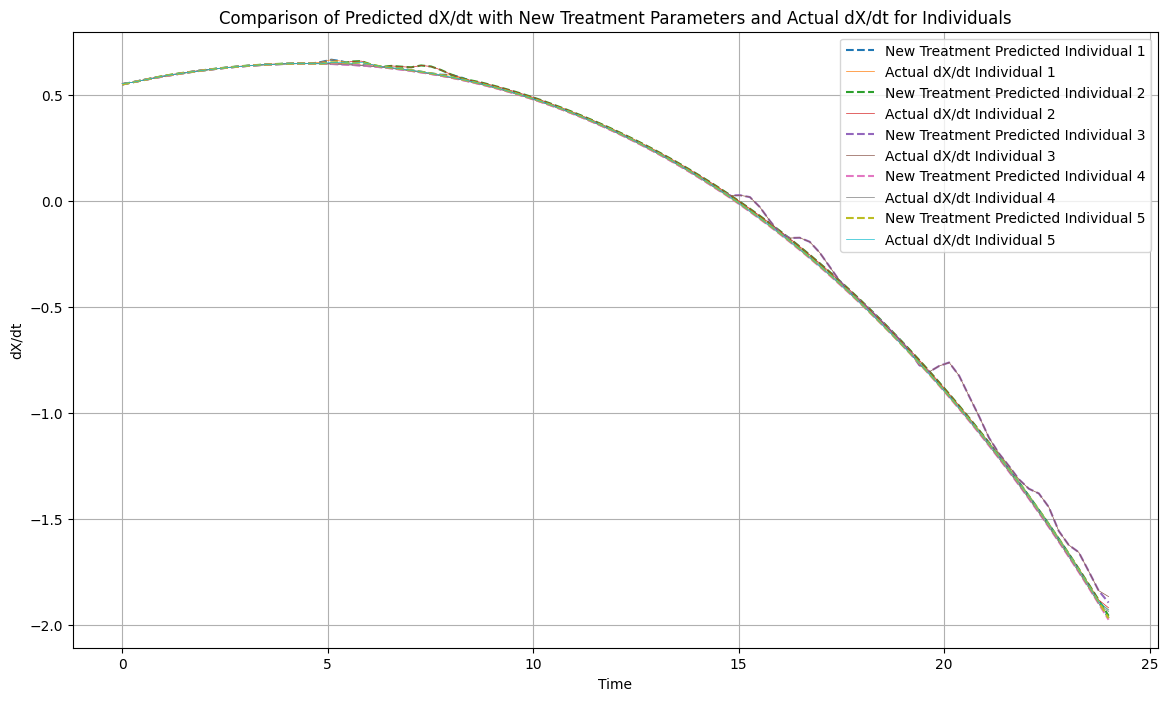

In [127]:
def generate_new_predictions(num_individuals, population_params, phi, time_points, treatment_params):
    results_concentration_new = []
    results_volume_new = []

    for _ in range(num_individuals):
        y0 = [1, 1]  # Initial drug concentration and cancer volume

        # Solve ODE with the provided treatment parameters
        res = solve_ivp(pkpd_model, [time_points[0], time_points[-1]], y0, 
                         args=(population_params, phi, treatment_params), t_eval=time_points)


        # Check if the solver was successful
        if not res.success:
            print(f"Warning: Integration failed for individual {_}. Message: {res.message}")
            continue  # Skip this individual if it failed

        
        results_concentration_new.append(res.y[0])
        results_volume_new.append(res.y[1])

    return np.array(results_concentration_new), np.array(results_volume_new)

# Generate new predictions under the modified treatment scenario
results_concentration_new, results_volume_new = generate_new_predictions(num_individuals, population_params, phi, time_points, new_treatment_params)

# Calculate dX/dt for new predictions
dX_dt_new = np.array([np.gradient(results_volume_new[i], time_points, edge_order=2) for i in range(num_individuals)])

# Predict cancer volumes for all individuals with new treatment conditions
predicted_cancer_volumes_new = predict_cancer_volume(dX_dt_new, initial_volume=1, time_points=time_points)

# Visualize predicted vs actual dX/dt with new treatment parameters
plt.figure(figsize=(14, 8))

for i in range(num_individuals):
    plt.plot(time_points, dX_dt_new[i], label=f"New Treatment Predicted Individual {i + 1}", linestyle='--')
    plt.plot(time_points, np.gradient(results_volume_new[i], time_points), label=f"Actual dX/dt Individual {i + 1}", linewidth=0.5)

plt.xlabel("Time")
plt.ylabel("dX/dt") 
plt.title("Comparison of Predicted dX/dt with New Treatment Parameters and Actual dX/dt for Individuals")
plt.legend()
plt.grid()
plt.show()

In [128]:
treatments = [
    {'dose': 5, 'probability': 0.4},
    {'dose': 7, 'probability': 0.5},
    {'dose': 1, 'probability': 0.6},
    {'dose': 8, 'probability': 0.7},
    {'dose': 6, 'probability': 0.8},
    {'dose': 2, 'probability': 0.5},
    {'dose': 5, 'probability': 0.6},
    {'dose': 2, 'probability': 0.7},
    {'dose': 3, 'probability': 0.9},
    {'dose': 9, 'probability': 0.3},
]

In [129]:
# Function to calculate Mean Squared Error
def calculate_mse(true_values, predicted_values):
    return np.mean((true_values - predicted_values) ** 2)

# Function to compute ground truth data (same as before)
def generate_ground_truth_data(num_individuals, population_params, phi, t, treatments):
    gt_results = []

    for _ in range(num_individuals):
        y0 = [10, 1]  # Initial drug concentration and cancer volume
        individual_gt_results = []
        
        for treatment_params in treatments:
            # Solve for each treatment
            res = solve_ivp(pkpd_model, [t[0], t[-1]], y0, 
                             args=(population_params, phi, treatment_params), t_eval=t)
            individual_gt_results.append(res.y[1])  # Store predicted cancer volume
        
        gt_results.append(individual_gt_results)  # Append individual results

    return np.array(gt_results)  # Return a 3D array

# Function to calculate individual metrics including latent variables
def calculate_individual_metrics(treatments, num_individuals, population_params, phi, time_points, actual_volumes, individual_betas_latent):
    individual_mse = []
    
    for treatment_index in range(len(treatments)):
        # Generate actual volumes for the current treatment
        actual_volume_for_treatment = actual_volumes[:, treatment_index, :]

        # Generate predictions for the current treatment using latent model
        results_concentration_new, results_volume_new = generate_new_predictions(num_individuals, population_params, phi, time_points, treatments[treatment_index])

        # Calculate dX/dt for the new predictions
        dX_dt_new = np.array([np.gradient(results_volume_new[i], time_points) for i in range(num_individuals)])

        # Predict cancer volumes for all individuals with the current treatment
        predicted_cancer_volumes_new = predict_cancer_volume(dX_dt_new, initial_volume=1, time_points=time_points)

        # Calculate metrics for each individual
        for i in range(num_individuals):
            mse = calculate_mse(actual_volume_for_treatment[i], predicted_cancer_volumes_new[i])

            if len(individual_mse) <= i:
                individual_mse.append([])  # Initialize inner list for individual MSE

            individual_mse[i].append(mse)

    # Average MSE and standard deviation for each individual
    average_mse = [np.mean(mse) for mse in individual_mse]
    std_deviation_mse = [np.std(mse) for mse in individual_mse]  # Standard deviation for each individual

    return average_mse, std_deviation_mse

# Assuming you want to compare MSE for the treatments
actual_volumes = generate_ground_truth_data(num_individuals, population_params, phi, time_points, treatments)

# Calculate individual metrics including latent variables
average_mse_list, std_deviation_mse_list = calculate_individual_metrics(treatments, num_individuals, population_params, phi, time_points, actual_volumes, individual_betas)

# Print average MSE and standard deviation for each individual
for i in range(num_individuals):
    print(f"Individual {i + 1} - Average MSE across treatments: {average_mse_list[i]:.4f}, Standard Deviation: {std_deviation_mse_list[i]:.4f}")

# Optionally calculate overall averages
overall_average_mse = np.mean(average_mse_list)
overall_std_deviation_mse = np.std(average_mse_list)

print(f"Population - Average MSE across treatments: {overall_average_mse:.4f}, Overall Standard Deviation: {overall_std_deviation_mse:.4f}")

Individual 1 - Average MSE across treatments: 22.9115, Standard Deviation: 2.9746
Individual 2 - Average MSE across treatments: 22.6027, Standard Deviation: 2.2447
Individual 3 - Average MSE across treatments: 22.6041, Standard Deviation: 2.6992
Individual 4 - Average MSE across treatments: 22.3483, Standard Deviation: 2.3843
Individual 5 - Average MSE across treatments: 22.6067, Standard Deviation: 2.4725
Population - Average MSE across treatments: 22.6146, Overall Standard Deviation: 0.1785


In [130]:
def calculate_average_mse(treatments, num_individuals, population_params, phi, time_points, actual_volumes):
    average_mse = []
    std_deviation_mse = []

    for treatment_index, treatment in enumerate(treatments):
        # Generate predictions for the current treatment regimen
        results_concentration_new, results_volume_new = generate_new_predictions(num_individuals, population_params, phi, time_points, treatment)

        # Calculate dX/dt for the new predictions
        if len(results_volume_new) == 0:
            print("No results generated, skipping this treatment.")
            continue
        
        dX_dt_new = np.array([np.gradient(results_volume_new[i], time_points) for i in range(len(results_volume_new))])

        # Predict cancer volumes for all individuals with the current treatment
        predicted_cancer_volumes_new = predict_cancer_volume(dX_dt_new, initial_volume=1, time_points=time_points)
        
        # Calculate MSE for each individual using the specified treatment index
        mse_list = []
        for i in range(len(results_volume_new)):  # Use the actual number of results generated
            mse = calculate_mse(actual_volumes[i][treatment_index], predicted_cancer_volumes_new[i])  # Assuming calculate_mse function is defined
            mse_list.append(mse)
        
        # Aggregate MSE for this treatment
        average_mse.append(np.mean(mse_list))
        std_deviation_mse.append(np.std(mse_list))  # Calculate standard deviation of MSEs

    return average_mse, std_deviation_mse  # Return both average and standard deviation

# Assuming you want to compare MSE for the first treatment
actual_volumes = generate_ground_truth_data(num_individuals, population_params, phi, time_points, treatments)

# Calculate average MSE and standard deviation for each treatment
average_mse_list, std_deviation_mse_list = calculate_average_mse(treatments, num_individuals, population_params, phi, time_points, actual_volumes)

# Print the average MSE and standard deviation for each treatment
for i, (mse, std) in enumerate(zip(average_mse_list, std_deviation_mse_list)):
    print(f"Average MSE for Treatment {i + 1} (Dose: {treatments[i]['dose']}, Probability: {treatments[i]['probability']}): {mse:.4f}, Standard Deviation: {std:.4f}")

Average MSE for Treatment 1 (Dose: 5, Probability: 0.4): 20.6088, Standard Deviation: 0.3342
Average MSE for Treatment 2 (Dose: 7, Probability: 0.5): 21.8653, Standard Deviation: 0.4363
Average MSE for Treatment 3 (Dose: 1, Probability: 0.6): 20.5058, Standard Deviation: 0.5040
Average MSE for Treatment 4 (Dose: 8, Probability: 0.7): 27.6569, Standard Deviation: 0.8262
Average MSE for Treatment 5 (Dose: 6, Probability: 0.8): 27.6299, Standard Deviation: 0.5685
Average MSE for Treatment 6 (Dose: 2, Probability: 0.5): 20.4684, Standard Deviation: 0.3164
Average MSE for Treatment 7 (Dose: 5, Probability: 0.6): 22.4087, Standard Deviation: 0.3358
Average MSE for Treatment 8 (Dose: 2, Probability: 0.7): 21.8232, Standard Deviation: 0.6248
Average MSE for Treatment 9 (Dose: 3, Probability: 0.9): 24.1408, Standard Deviation: 0.1600
Average MSE for Treatment 10 (Dose: 9, Probability: 0.3): 19.2417, Standard Deviation: 0.0759


# NO LATENT Approach 

In [132]:
# Build feature library for SINDy without latent variables
def build_feature_library_no_latent(X):
    A = np.column_stack([X, X**2])  # Only include X and its square to fit dynamics
    return A

def fit_population_dynamics_sindy(X, Z):
    """ Fit the population dynamics using SINDy approach. """
    A = build_feature_library_no_latent(X)  # Create feature space excluding latent variables
    dX_dt = np.gradient(Z, time_points)  # Calculate dX/dt

    lasso = Lasso(alpha=0.01, fit_intercept=False)
    print(A.shape, dX_dt.shape)
    lasso.fit(A, dX_dt)
    return lasso.coef_  # Returns estimated coefficients for the population model


def fit_population_dynamics_no_latent(t, dX_dt, feature_library):
    """Fit the population dynamics using SINDy approach without latent variables."""
    # dX/dt is the change in cancer volume, we assume Z correlates with this
    Y = dX_dt  # Actual dX/dt from individual data

    lasso = Lasso(alpha=0.01, fit_intercept=False)  # Regularization parameter
    lasso.fit(feature_library, Y)  # Fit the model
    return lasso.coef_

In [133]:
# Fine-tune for individual-specific dynamics using their fitted latent coefficients
def fine_tune_individual_dynamics(X_i, dX_dt_i, feature_library, beta_est, lambda_reg=0.1):
    def loss_function(beta_i):
        mse_loss = np.mean((dX_dt_i - feature_library @ beta_i) ** 2)
        reg_loss = lambda_reg * np.sum((beta_est - beta_i) ** 2)
        return mse_loss + reg_loss

    res = minimize(loss_function, beta_est, method="L-BFGS-B")
    return res.x

In [134]:
def predict_dX_dt_no_latent(X, Z, individual_betas_no_latent):
    dX_dt_predictions = []
    
    for i, beta_individual in enumerate(individual_betas_no_latent):
        if len(beta_individual) == 2:
            # Only using the respective X[i] for computation as we don't have latent variables
            dX_dt_i = (beta_individual[0] * X[i] * (1 - X[i] / 10) +
                        beta_individual[1] * Z)
        else:
            # If additional coefficients exist (for debugging, if needed)
            dX_dt_i = (beta_individual[0] * X[i] * (1 - X[i] / 10) +
                        beta_individual[1] * Z +
                        beta_individual[2] * np.sin(np.array(time_points)))  # Fall back to previous behavior

        dX_dt_predictions.append(dX_dt_i)
    
    return np.array(dX_dt_predictions) 

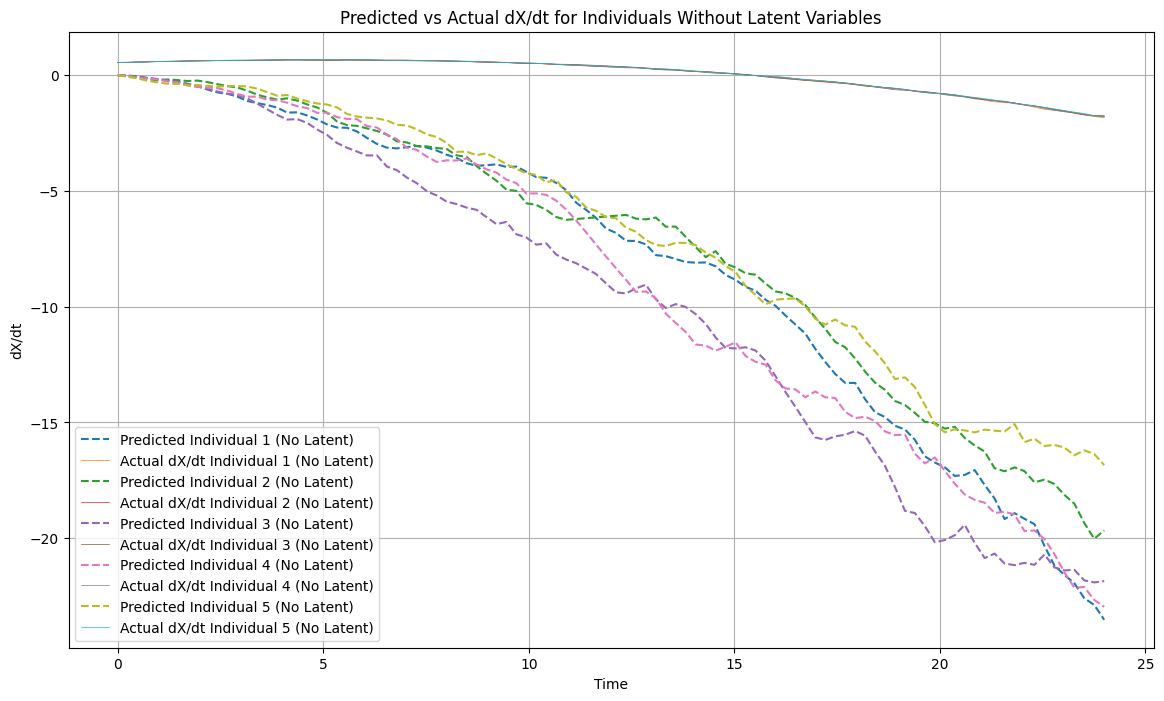

In [135]:
#results_concentration, results_volume, mean_concentration, mean_volume, latent_values = generate_pkpd_data(num_individuals, population_params, phi, time_points)

# Calculate dX/dt for each individual
individual_dX_dt = [np.gradient(results_volume[i], time_points) for i in range(num_individuals)]

# Build the feature library without latent variables
feature_libraries_no_latent = [build_feature_library_no_latent(results_concentration[i]) for i in range(num_individuals)]

# Fit the population-level ODE without latent influence
beta_est_no_latent = fit_population_dynamics_no_latent(time_points, individual_dX_dt[0], feature_libraries_no_latent[0])

# Fine-tune for individual-specific dynamics without latent variables
individual_betas_no_latent = []
for i in range(num_individuals):
    beta_individual_no_latent = fine_tune_individual_dynamics(results_concentration[i], individual_dX_dt[i], feature_libraries_no_latent[i], beta_est_no_latent)
    individual_betas_no_latent.append(beta_individual_no_latent)

# Print results for each individual
# print('\nIndividual Coefficients (Fitted Without Latent):')
# for i in range(num_individuals):
#     print(f"Individual {i + 1} fitted beta: {individual_betas_no_latent[i]}")

# Predict dX/dt using inferred coefficients for each individual without latent influence
dX_dt_predicted_no_latent = predict_dX_dt_no_latent(results_concentration, np.zeros(time_points.shape), individual_betas_no_latent)

# Plotting results for individuals and predictions without latent influence
plt.figure(figsize=(14, 8))

# Comparison of predicted and actual dX/dt for individuals without latent influence
for i in range(num_individuals):
    plt.plot(time_points, dX_dt_predicted_no_latent[i], label=f"Predicted Individual {i + 1} (No Latent)", linestyle='--')
    plt.plot(time_points, individual_dX_dt[i], label=f"Actual dX/dt Individual {i + 1} (No Latent)", linewidth=0.5)

plt.xlabel("Time")
plt.ylabel("dX/dt")
plt.title("Predicted vs Actual dX/dt for Individuals Without Latent Variables")
plt.legend()
plt.grid()
plt.show()

In [136]:
# Function to calculate Mean Squared Error
def calculate_mse(true_values, predicted_values):
    return np.mean((true_values - predicted_values) ** 2)

# Function to calculate R² (Goodness-of-Fit)
def calculate_r_squared(true_values, predicted_values):
    ss_res = np.sum((true_values - predicted_values) ** 2)  # Residual sum of squares
    ss_tot = np.sum((true_values - np.mean(true_values)) ** 2)  # Total sum of squares
    return 1 - (ss_res / ss_tot)  # R² value

# Compute and print metrics for each individual
mse_values_no_latent = []
r_squared_values_no_latent = []

for i in range(num_individuals):
    # Actual dX/dt for the individual
    actual_dX_dt = individual_dX_dt[i]
    # Predicted dX/dt for the individual
    predicted_dX_dt = dX_dt_predicted_no_latent[i]

    mse = calculate_mse(actual_dX_dt, predicted_dX_dt)
    r_squared = calculate_r_squared(actual_dX_dt, predicted_dX_dt)

    mse_values_no_latent.append(mse)
    r_squared_values_no_latent.append(r_squared)

    print(f"Individual {i + 1} - MSE: {mse:.4f}, R²: {r_squared:.4f}")

# Calculate and print population-level metrics
population_mse_no_latent = calculate_mse(np.concatenate(individual_dX_dt), np.concatenate(dX_dt_predicted_no_latent))
population_r_squared_no_latent = calculate_r_squared(np.concatenate(individual_dX_dt), np.concatenate(dX_dt_predicted_no_latent))

print(f"Population (No Latent) - MSE: {population_mse_no_latent:.4f}, R²: {population_r_squared_no_latent:.4f}")

Individual 1 - MSE: 105.0675, R²: -195.6674
Individual 2 - MSE: 84.3805, R²: -161.1123
Individual 3 - MSE: 140.6751, R²: -270.3508
Individual 4 - MSE: 120.9484, R²: -229.5828
Individual 5 - MSE: 72.8651, R²: -140.6014
Population (No Latent) - MSE: 104.7873, R²: -199.5560


## Average MSE : 10 runs : No Latent

In [112]:
# Settings for the experiment
num_individuals = 10
num_runs = 50  # Number of simulations
mse_values = []

for run in range(num_runs):
    # Generate Data
    results_concentration, results_volume, _, _, _ = generate_pkpd_data(num_individuals, population_parameters, phi, time_points)

    # Calculate dX/dt for each individual
    individual_dX_dt = [np.gradient(results_volume[i], time_points) for i in range(num_individuals)]

    # Build the feature library without latent variables
    feature_libraries_no_latent = [build_feature_library_no_latent(results_concentration[i]) for i in range(num_individuals)]

    # Initialize beta estimates
    individual_betas_no_latent = []

    for i in range(num_individuals):
        X_i = results_concentration[i]  # Individual drug concentration


        # Build feature library for the individual
        feature_library_i = build_feature_library_no_latent(X_i)

        # Start with zero estimates for beta
        beta_est = np.zeros(feature_library_i.shape[1])
        beta_individual_no_latent = fine_tune_individual_dynamics(results_concentration[i], individual_dX_dt[i], feature_libraries_no_latent[i], beta_est_no_latent)
        individual_betas_no_latent.append(beta_individual)

    # Predict dX/dt using inferred coefficients for each individual without latent influence
    V = np.mean(results_volume, axis=0)  # Average cancer volume across individuals
    dX_dt_predicted_latent = predict_dX_dt_no_latent(results_concentration, V, individual_betas_no_latent)

    # Calculate MSE for this run
    mse_run = []
    for i in range(num_individuals):
        mse = calculate_mse(individual_dX_dt[i], dX_dt_predicted_latent[i])
        mse_run.append(mse)

    # Append the run's MSE values to the overall list
    mse_values.append(mse_run)

# Convert to array for further analysis
mse_values = np.array(mse_values)

# Calculate average MSE and standard deviation across runs for each individual
average_mse = np.mean(mse_values, axis=0)
std_deviation_mse = np.std(mse_values, axis=0)

# Print the results
for i in range(num_individuals):
    print(f"Individual {i + 1} - Average MSE: {average_mse[i]:.4f}, Standard Deviation: {std_deviation_mse[i]:.4f}")

# Calculate and print overall averages for the population
overall_average_mse = np.mean(average_mse)
overall_std_deviation_mse = np.mean(std_deviation_mse)

print(f"Overall Average MSE across all individuals: {overall_average_mse:.4f}, Overall Standard Deviation: {overall_std_deviation_mse:.4f}")

TypeError: list indices must be integers or slices, not str

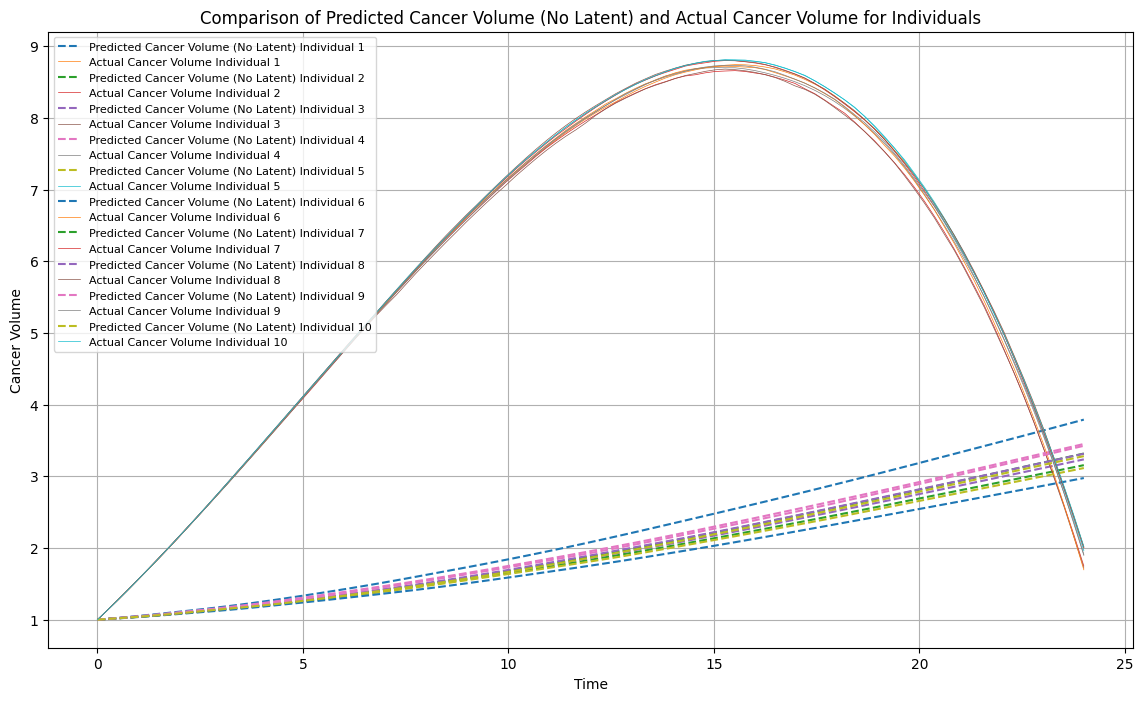

In [96]:
def predict_dX_dt_no_latent(X, individual_betas, concentration_data):
    """Predict dX/dt for all individuals without incorporating latent variables."""
    dX_dt_predictions = []
    
    for i, beta_individual in enumerate(individual_betas):
        # Calculate dX/dt using only the beta coefficients relevant to this model
        C = concentration_data[i]  # Array of drug concentration for individual i
        dX_dt_i = (beta_individual[0] * X[i] * (1 - X[i] / 10) +  # Effect of drug concentration and volume
                    beta_individual[1] * C)  # Direct effect from the coefficient without latent influence
        
        dX_dt_predictions.append(dX_dt_i)
    
    return np.array(dX_dt_predictions)

# Calculate the predicted dX/dt for all individuals using their inferred betas without latent effects
dX_dt_predicted_no_latent = predict_dX_dt_no_latent(results_volume, individual_betas_no_latent, results_concentration)


# Function to predict cancer volume from predicted dX/dt without latent effects
def predict_cancer_volume_no_latent(dX_dt, initial_volume, time_points):
    predicted_volumes = []
    
    for dX in dX_dt:
        def dXdt(t, x):
            return dX[int(np.clip(t, 0, len(dX) - 1))]  # Ensure appropriate indexing

        # Solve the ODE to obtain cancer volume over time
        sol = solve_ivp(dXdt, [time_points[0], time_points[-1]], [initial_volume], t_eval=time_points)
        predicted_volume = sol.y[0]  # Extract the predicted cancer volume from the solution
        predicted_volumes.append(predicted_volume)

    return np.array(predicted_volumes)

# Predict cancer volumes using the predicted dX/dt without latent effects
predicted_cancer_volumes_no_latent = predict_cancer_volume_no_latent(dX_dt_predicted_no_latent, 1, time_points)

# Plotting results for individuals and comparisons between predicted and actual cancer volumes without latent influence
plt.figure(figsize=(14, 8))

for i in range(num_individuals):
    plt.plot(time_points, predicted_cancer_volumes_no_latent[i], 
             label=f"Predicted Cancer Volume (No Latent) Individual {i + 1}", linestyle='--')
    plt.plot(time_points, results_volume[i], 
             label=f"Actual Cancer Volume Individual {i + 1}", linewidth=0.5)

plt.xlabel("Time")
plt.ylabel("Cancer Volume")
plt.title("Comparison of Predicted Cancer Volume (No Latent) and Actual Cancer Volume for Individuals")
plt.legend(fontsize=8)  # You can specify an exact size
plt.grid()
plt.show()

### No Latent Framework Average Treatment Analysis

In [137]:
# Calculate MSE across all treatments
individual_mse = []

# Loop over each treatment and calculate individual metrics
for treatment_index in range(len(treatments)):
    # Generate actual volumes for the current treatment
    actual_volumes = generate_ground_truth_data(num_individuals, population_params, phi, time_points, [treatments[treatment_index]])

    # Estimate dX/dt and cancer volumes for the current treatment
    dX_dt_predicted_no_latent = predict_dX_dt_no_latent(results_concentration, np.zeros(time_points.shape), individual_betas_no_latent)

    # Store metrics for this treatment
    mse_values = []

    for i in range(num_individuals):
        # Actual dX/dt for the individual
        actual_dX_dt = individual_dX_dt[i]
        # Predicted dX/dt for the individual
        predicted_dX_dt = dX_dt_predicted_no_latent[i]

        # Calculate MSE
        mse = calculate_mse(actual_dX_dt, predicted_dX_dt)

        mse_values.append(mse)

    # Append the metrics for this treatment
    individual_mse.append(mse_values)

# Calculate averages and standard deviations for each individual across treatments
average_mse = np.mean(np.array(individual_mse), axis=0)
std_deviation_mse = np.std(np.array(individual_mse), axis=0)  # Standard deviation for each individual

# Print the average MSE and standard deviation for each individual
for i in range(num_individuals):
    print(f"Individual {i + 1} - Average MSE across treatments: {average_mse[i]:.4f}, Standard Deviation: {std_deviation_mse[i]:.4f}")

# Compute overall averages for the population
overall_average_mse = np.mean(average_mse)
overall_std_deviation_mse = np.mean(std_deviation_mse)  # Overall standard deviation

print(f"Population - Average MSE across treatments: {overall_average_mse:.4f}, Overall Standard Deviation: {overall_std_deviation_mse:.4f}")

Individual 1 - Average MSE across treatments: 105.0675, Standard Deviation: 0.0000
Individual 2 - Average MSE across treatments: 84.3805, Standard Deviation: 0.0000
Individual 3 - Average MSE across treatments: 140.6751, Standard Deviation: 0.0000
Individual 4 - Average MSE across treatments: 120.9484, Standard Deviation: 0.0000
Individual 5 - Average MSE across treatments: 72.8651, Standard Deviation: 0.0000
Population - Average MSE across treatments: 104.7873, Overall Standard Deviation: 0.0000


In [122]:
# Function to calculate average MSE for each treatment
def calculate_average_metrics_per_treatment(treatments, num_individuals, population_params, phi, time_points, actual_volumes, individual_betas_no_latent):
    treatment_mse = []
    treatment_std_deviation_mse = []  # To store standard deviation of MSE for each treatment

    for treatment_index in range(len(treatments)):
        # Generate actual volumes for the current treatment
        actual_volume_for_treatment = actual_volumes[:, treatment_index, :]

        # Generate predictions for the current treatment
        results_concentration_new, results_volume_new = generate_new_predictions(num_individuals, population_params, phi, time_points, treatments[treatment_index])
        
        dX_dt_new = np.array([np.gradient(results_volume_new[i], time_points) for i in range(len(results_volume_new))])

        # Predict cancer volumes for all individuals with the current treatment
        predicted_cancer_volumes_new = predict_cancer_volume(dX_dt_new, initial_volume=1, time_points=time_points)

        # Calculate metrics for each individual
        mse_list = []

        for i in range(num_individuals):  # Assuming predicted_cancer_volumes_new and actual_volume_for_treatment are aligned
            mse = calculate_mse(actual_volume_for_treatment[i], predicted_cancer_volumes_new[i])
            mse_list.append(mse)

        # Average metrics for this treatment
        avg_mse = np.mean(mse_list)
        std_deviation_mse = np.std(mse_list)  # Calculate standard deviation of MSE

        treatment_mse.append(avg_mse)
        treatment_std_deviation_mse.append(std_deviation_mse)  # Append standard deviation

        print(f"Average MSE for Treatment {treatment_index + 1} (Dose: {treatments[treatment_index]['dose']}, Probability: {treatments[treatment_index]['probability']}): {avg_mse:.4f}, Standard Deviation: {std_deviation_mse:.4f}")

    return treatment_mse, treatment_std_deviation_mse

# Assuming you want to compare MSE for the treatments
actual_volumes_no_latent = generate_ground_truth_data(num_individuals, population_params, phi, time_points, treatments)

# Calculate average metrics for each treatment
treatment_mse_list, treatment_std_deviation_list = calculate_average_metrics_per_treatment(treatments, num_individuals, population_params, phi, time_points, actual_volumes_no_latent, individual_betas_no_latent)

Average MSE for Treatment 1 (Dose: 5, Probability: 0.4): 20.3532, Standard Deviation: 0.3617
Average MSE for Treatment 2 (Dose: 7, Probability: 0.5): 22.0713, Standard Deviation: 0.4022
Average MSE for Treatment 3 (Dose: 1, Probability: 0.6): 20.5330, Standard Deviation: 0.4398
Average MSE for Treatment 4 (Dose: 8, Probability: 0.7): 27.6557, Standard Deviation: 2.1768
Average MSE for Treatment 5 (Dose: 6, Probability: 0.8): 26.8166, Standard Deviation: 0.9441
Average MSE for Treatment 6 (Dose: 2, Probability: 0.5): 20.5828, Standard Deviation: 0.3355
Average MSE for Treatment 7 (Dose: 5, Probability: 0.6): 22.1911, Standard Deviation: 0.5871
Average MSE for Treatment 8 (Dose: 2, Probability: 0.7): 21.6017, Standard Deviation: 0.5287
Average MSE for Treatment 9 (Dose: 3, Probability: 0.9): 24.0550, Standard Deviation: 0.3849
Average MSE for Treatment 10 (Dose: 9, Probability: 0.3): 20.0376, Standard Deviation: 0.4713


## Population-level Analysis

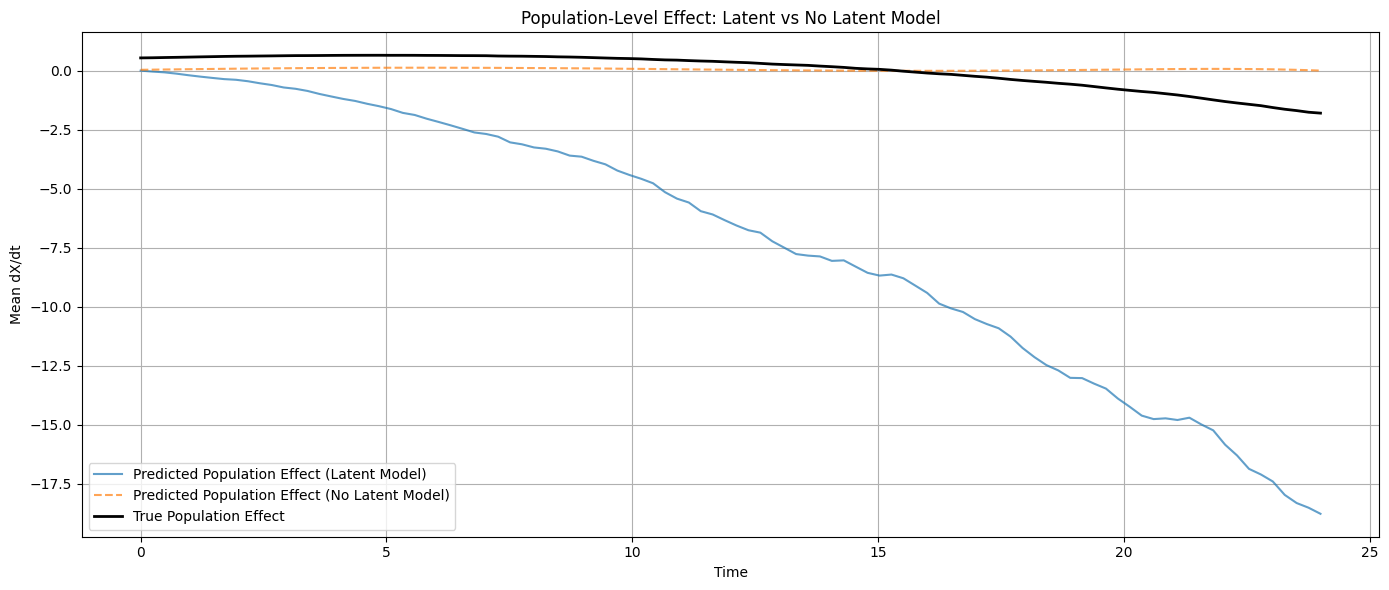

In [105]:
# Generate dX/dt predictions for the population level with latent influence
dX_dt_predicted_with_latent = np.mean(dX_dt_predicted, axis=0)

# Generate dX/dt predictions for the population level without latent influence
dX_dt_predicted_no_latent = np.mean(dX_dt_predicted_no_latent, axis=0)

# Calculate the ground truth dX/dt
dX_dt_ground_truth = np.mean(individual_dX_dt, axis=0)  # Assuming individual_dX_dt is already computed

# Plot: Population-level comparison for latent vs. no latent model
plt.figure(figsize=(14, 6))

# Plot predictions with latent model
plt.plot(time_points, dX_dt_predicted_with_latent, label='Predicted Population Effect (Latent Model)', alpha=0.7)

# Plot predictions with direct model (no latent variables)
plt.plot(time_points, dX_dt_predicted_no_latent, linestyle='--', label='Predicted Population Effect (No Latent Model)', alpha=0.7)

# Plot ground truth
plt.plot(time_points, dX_dt_ground_truth, label='True Population Effect', color='black', linewidth=2)

# Title and labels
plt.title("Population-Level Effect: Latent vs No Latent Model")
plt.xlabel("Time")
plt.ylabel("Mean dX/dt")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()